## Word Embeddings 

This file is meant for preprocessing our final dataset into a proper training set for Word2Vec, as well as building the model itself using Tensorflow and Gensim.

In [1]:
import numpy as np
import tensorflow as tf
import pickle
from sklearn import manifold
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# loading datasets
data_folder = '/Users/vibhav/Desktop/rp-project-data'
classical = pickle.load(open(data_folder + '/classical.pkl', mode='rb'))
romantic = pickle.load(open(data_folder + '/romantic.pkl', mode='rb'))
victorian = pickle.load(open(data_folder + '/victorian.pkl', mode='rb'))
modern = pickle.load(open(data_folder + '/modern.pkl', mode='rb'))

### Generating Training Data

In [3]:
def standardization(sent):
    sent = tf.strings.lower(sent)
    return tf.strings.regex_replace(sent, '[^a-zA-Z\s]', '')

vocab_size = 5000
seq_length = 10

#text vectorizer for every dataset
ro_vectorizer_layer = tf.keras.layers.TextVectorization(standardize=standardization, output_mode='int', max_tokens=vocab_size, output_sequence_length=seq_length, split='whitespace')
vi_vectorizer_layer = tf.keras.layers.TextVectorization(standardize=standardization, output_mode='int', max_tokens=vocab_size, output_sequence_length=seq_length, split='whitespace')
mo_vectorizer_layer = tf.keras.layers.TextVectorization(standardize=standardization, output_mode='int', max_tokens=vocab_size, output_sequence_length=seq_length, split='whitespace')

#extracting training samples

ro_dataset = tf.data.Dataset.from_tensor_slices(np.random.choice(romantic['sentences'], 10000))
vi_dataset = tf.data.Dataset.from_tensor_slices(np.random.choice(victorian['sentences'], 10000))
mo_dataset = tf.data.Dataset.from_tensor_slices(np.random.choice(modern['sentences'], 10000))

#fitting vectorize layer to corpus
ro_vectorizer_layer.adapt(ro_dataset.batch(500))
vi_vectorizer_layer.adapt(vi_dataset.batch(500))
mo_vectorizer_layer.adapt(mo_dataset.batch(500))

ro_vocab = ro_vectorizer_layer.get_vocabulary()
vi_vocab = vi_vectorizer_layer.get_vocabulary()
mo_vocab = mo_vectorizer_layer.get_vocabulary()

ro_int_sents = ro_dataset.batch(500).prefetch(tf.data.AUTOTUNE).map(ro_vectorizer_layer).unbatch()
vi_int_sents = vi_dataset.batch(500).prefetch(tf.data.AUTOTUNE).map(vi_vectorizer_layer).unbatch()
mo_int_sents = mo_dataset.batch(500).prefetch(tf.data.AUTOTUNE).map(mo_vectorizer_layer).unbatch()

ro_seqs = list(ro_int_sents.as_numpy_iterator())
vi_seqs = list(vi_int_sents.as_numpy_iterator())
mo_seqs = list(mo_int_sents.as_numpy_iterator())

2022-04-24 03:44:57.907270: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [4]:
# generating skip-grams
ro_ds = np.array([], dtype=object)
ro_labels = np.array([], dtype=object)
vi_ds = np.array([], dtype=object)
vi_labels = np.array([], dtype=object)
mo_ds = np.array([], dtype=object)
mo_labels = np.array([], dtype=object)
count = 0
for s in ro_seqs:
    sg, ls = tf.keras.preprocessing.sequence.skipgrams(s, vocabulary_size=len(ro_vocab), window_size=5, negative_samples=0)
    ro_ds = np.append(ro_ds, sg)
    ro_labels = np.append(ro_labels, ls)
print('romantic done')
for s in vi_seqs:
    sg, ls = tf.keras.preprocessing.sequence.skipgrams(s, vocabulary_size=len(vi_vocab), window_size=5, negative_samples=0)
    vi_ds = np.append(vi_ds, sg)
    vi_labels = np.append(vi_labels, ls)
print('victorian done')
for s in mo_seqs:
    sg, ls = tf.keras.preprocessing.sequence.skipgrams(s, vocabulary_size=len(mo_vocab), window_size=5, negative_samples=0)
    mo_ds = np.append(mo_ds, sg)
    mo_labels = np.append(mo_labels, ls)
print('modern done')

romantic done
victorian done
modern done


In [5]:
tens = lambda l: tf.convert_to_tensor(l, dtype=tf.int32)
if len(ro_ds)%2 != 0:
    ro_ds = np.append(ro_ds, 0)
if len(vi_ds)%2 != 0:
    vi_ds = np.append(vi_ds, 0)
if len(mo_ds)%2 != 0:
    mo_ds = np.append(mo_ds, 0)
r = len(ro_ds)
v = len(vi_ds)
m = len(mo_ds)
ro_d = np.reshape(ro_ds, (r//2, 2))
vi_d = np.reshape(vi_ds, (v//2, 2))
mo_d = np.reshape(mo_ds, (m//2, 2))
print(ro_d.shape[0])
print(len(ro_labels))
if ro_d.shape[0] < len(ro_labels):
    print('helcs')
    ro_l = ro_labels[:len(ro_labels)-2]
else:
    ro_l = np.append(ro_labels, np.zeros(ro_d.shape[0]-len(ro_labels)))
if vi_d.shape[0] < len(vi_labels):
    vi_l = vi_labels[:len(vi_labels)-2]
else:
    vi_l = np.append(vi_labels, np.zeros(vi_d.shape[0]-len(vi_labels)))
if mo_d.shape[0] < len(mo_labels):
    mo_l = mo_labels[:len(mo_labels)-2]
else:
    mo_l = np.append(mo_labels, np.zeros(mo_d.shape[0]-len(mo_labels)))

607550
607550


In [6]:
print(len(ro_l))
print(ro_d.shape[0])
assert len(ro_l) == ro_d.shape[0]
assert len(vi_l) == vi_d.shape[0]
assert len(mo_l) == mo_d.shape[0]
ro_dst = tens(ro_d)
ro_labelst = tens(ro_l)
vi_dst = tens(vi_d)
vi_labelst = tens(vi_l)
mo_dst = tens(mo_d)
mo_labelst = tens(mo_l)

ro_data = tf.data.Dataset.from_tensor_slices(((ro_dst[:, 0], ro_dst[:, 1]), ro_labelst))
vi_data = tf.data.Dataset.from_tensor_slices(((vi_dst[:, 0], vi_dst[:, 1]), vi_labelst))
mo_data = tf.data.Dataset.from_tensor_slices(((mo_dst[:, 0], mo_dst[:, 1]), mo_labelst))
rom = np.array(list(ro_data.as_numpy_iterator()))
vic = np.array(list(vi_data.as_numpy_iterator()))
mod = np.array(list(mo_data.as_numpy_iterator()))

607550
607550


/var/folders/g5/p95y18kn7ljd88z8mc59xsdm0000gn/T/ipykernel_44177/1004917755.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rom = np.array(list(ro_data.as_numpy_iterator()))
/var/folders/g5/p95y18kn7ljd88z8mc59xsdm0000gn/T/ipykernel_44177/1004917755.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vic = np.array(list(vi_data.as_numpy_iterator()))
/var/folders/g5/p95y18kn7ljd88z8mc59xsdm0000gn/T/ipykernel_44177/1004917755.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-t

### Building the Model

In [7]:
def one_hot(vocab, index):
    vec = np.zeros(vocab)
    vec[index] = 1
    return vec

def gen_training_exs(vocab, ds):
    tc = ds[:, 0]
    labels = ds[:, 1]
    target = [t[0] for t in tc]
    context = [t[1] for t in tc]
    train_exs = np.empty((len(target), vocab), dtype=float)
    output_labels = np.empty((len(context), vocab), dtype=float)
    assert(train_exs.shape == output_labels.shape)
    for i in range(len(train_exs)):
        vec = one_hot(vocab, target[i])
        for j in range(len(vec)):
            train_exs[i][j] = vec[j]
    for i in range(len(train_exs)):
        vec = one_hot(vocab, context[i])
        for j in range(len(vec)):
            output_labels[i][j] = vec[j]
    return train_exs, output_labels

embed_dim = 128

class W2V():
    def __init__(self, vocab, embedding_dim):
        self.vocab = vocab
        self.dimen = embedding_dim

    def train(self, x, labels, epochs, learning_rate):
        self.opt = tf.optimizers.Adam()
        self.W1 = tf.Variable(tf.random.normal([self.vocab, self.dimen])) #embedding layer with linear activation
        self.b1 = tf.Variable(tf.random.normal([self.dimen])) #bias
        self.W2 = tf.Variable(tf.random.normal([self.dimen, self.vocab])) # dustribution layer with softmax activation
        self.b2 = tf.Variable(tf.random.normal([self.vocab]))
        
        for _ in range(epochs):
            with tf.GradientTape() as g:
                hidden_layer = tf.add(tf.matmul(x, self.W1),self.b1)
                output_layer = tf.nn.softmax(tf.add(tf.matmul(hidden_layer, self.W2), self.b2))
                loss = tf.reduce_mean(tf.reduce_sum(tf.math.xlog1py(labels, output_layer), axis=1)) #cross entropy of output label distribution and true distribution
            grads = g.gradient(loss, [self.W1, self.b1, self.W2, self.b2])
            self.opt.apply_gradients(zip(grads,[self.W1, self.b1, self.W2, self.b2]))
            if(_ % 20 == 0):
                print('loss: ', loss)
        return self.W1
        

        

## Training

In [8]:
ten_float = lambda l: tf.convert_to_tensor(l, dtype=tf.float32)
rom_train, rom_labels = gen_training_exs(vocab_size, rom[np.random.choice(rom.shape[0], 40000, replace=False), :])
w2v_romantic = W2V(vocab=vocab_size, embedding_dim=embed_dim)

ro_embeds = w2v_romantic.train(x=ten_float(rom_train), labels=ten_float(rom_labels), epochs=300, learning_rate=0.1)

loss:  tf.Tensor(2.3106802e-05, shape=(), dtype=float32)
loss:  tf.Tensor(8.7598244e-07, shape=(), dtype=float32)
loss:  tf.Tensor(3.6553055e-07, shape=(), dtype=float32)
loss:  tf.Tensor(2.4541256e-07, shape=(), dtype=float32)
loss:  tf.Tensor(1.8891201e-07, shape=(), dtype=float32)
loss:  tf.Tensor(1.537066e-07, shape=(), dtype=float32)
loss:  tf.Tensor(1.2901513e-07, shape=(), dtype=float32)
loss:  tf.Tensor(1.1065338e-07, shape=(), dtype=float32)
loss:  tf.Tensor(9.648061e-08, shape=(), dtype=float32)
loss:  tf.Tensor(8.523542e-08, shape=(), dtype=float32)
loss:  tf.Tensor(7.6115874e-08, shape=(), dtype=float32)
loss:  tf.Tensor(6.858591e-08, shape=(), dtype=float32)
loss:  tf.Tensor(6.227578e-08, shape=(), dtype=float32)
loss:  tf.Tensor(5.691917e-08, shape=(), dtype=float32)
loss:  tf.Tensor(5.2322296e-08, shape=(), dtype=float32)


In [9]:
print(ro_embeds)

<tf.Variable 'Variable:0' shape=(5000, 128) dtype=float32, numpy=
array([[ 0.69343877,  0.63411576,  2.1209626 , ..., -0.0539675 ,
         0.6925125 , -0.55157804],
       [ 0.9755625 , -0.94038826,  1.6885103 , ..., -0.75019795,
        -0.08198641, -1.0423757 ],
       [-0.2353969 ,  0.5781454 ,  1.8686509 , ..., -0.31173605,
        -1.5197934 , -0.7137193 ],
       ...,
       [ 0.27675822, -0.1687743 , -0.40268803, ...,  0.55240566,
        -1.008906  ,  0.24840368],
       [ 2.3865457 ,  0.8435614 ,  0.84811425, ...,  0.38239217,
        -1.0935806 ,  0.03152004],
       [ 0.5633037 ,  0.6691284 ,  0.57154775, ...,  0.1619901 ,
         1.2790054 ,  0.34737504]], dtype=float32)>


In [10]:
vic_train, vic_labels = gen_training_exs(vocab_size, vic[np.random.choice(vic.shape[0], 40000, replace=False), :])
w2v_victorian = W2V(vocab=vocab_size, embedding_dim=embed_dim)

vi_embeds = w2v_victorian.train(x=ten_float(vic_train), labels=ten_float(vic_labels), epochs=300, learning_rate=0.1)

loss:  tf.Tensor(9.192093e-05, shape=(), dtype=float32)
loss:  tf.Tensor(5.2939587e-05, shape=(), dtype=float32)
loss:  tf.Tensor(3.7263035e-05, shape=(), dtype=float32)
loss:  tf.Tensor(3.481323e-05, shape=(), dtype=float32)
loss:  tf.Tensor(2.497303e-05, shape=(), dtype=float32)
loss:  tf.Tensor(1.7500808e-05, shape=(), dtype=float32)
loss:  tf.Tensor(1.7471486e-05, shape=(), dtype=float32)
loss:  tf.Tensor(1.7449636e-05, shape=(), dtype=float32)
loss:  tf.Tensor(1.7431395e-05, shape=(), dtype=float32)
loss:  tf.Tensor(1.7413704e-05, shape=(), dtype=float32)
loss:  tf.Tensor(1.738709e-05, shape=(), dtype=float32)
loss:  tf.Tensor(1.7131037e-05, shape=(), dtype=float32)
loss:  tf.Tensor(1.1497091e-07, shape=(), dtype=float32)
loss:  tf.Tensor(8.796012e-08, shape=(), dtype=float32)
loss:  tf.Tensor(7.172105e-08, shape=(), dtype=float32)


In [11]:
print(vi_embeds)

<tf.Variable 'Variable:0' shape=(5000, 128) dtype=float32, numpy=
array([[-0.16408828,  0.50495946, -0.42818624, ...,  1.1918136 ,
        -0.16592975, -0.06681683],
       [-0.04638888, -0.4281443 ,  0.4270108 , ...,  0.1458849 ,
        -0.04898833,  0.3190463 ],
       [ 0.44393831, -0.6508018 , -0.8791974 , ...,  0.09038912,
        -0.25974166, -1.0296063 ],
       ...,
       [-0.09010698,  0.07856473,  0.41266605, ...,  0.11749893,
        -1.6386011 ,  2.01072   ],
       [ 0.36840898, -0.45533678, -2.8081355 , ..., -0.41538265,
        -0.37178382, -0.64833117],
       [ 0.67676747, -0.38676602,  0.36283383, ..., -0.12035744,
         0.25251436,  0.76832694]], dtype=float32)>


In [12]:
mod_train, mod_labels = gen_training_exs(vocab_size, mod[np.random.choice(mod.shape[0], 40000, replace=False), :])
w2v_victorian = W2V(vocab=vocab_size, embedding_dim=embed_dim)

mo_embeds = w2v_victorian.train(x=ten_float(mod_train), labels=ten_float(mod_labels), epochs=300, learning_rate=0.1)

loss:  tf.Tensor(9.312174e-05, shape=(), dtype=float32)
loss:  tf.Tensor(1.4420765e-06, shape=(), dtype=float32)
loss:  tf.Tensor(4.079762e-07, shape=(), dtype=float32)
loss:  tf.Tensor(2.7534767e-07, shape=(), dtype=float32)
loss:  tf.Tensor(2.2153942e-07, shape=(), dtype=float32)
loss:  tf.Tensor(1.8804202e-07, shape=(), dtype=float32)
loss:  tf.Tensor(1.6341454e-07, shape=(), dtype=float32)
loss:  tf.Tensor(1.4409933e-07, shape=(), dtype=float32)
loss:  tf.Tensor(1.2844765e-07, shape=(), dtype=float32)
loss:  tf.Tensor(1.1549166e-07, shape=(), dtype=float32)
loss:  tf.Tensor(1.0459572e-07, shape=(), dtype=float32)
loss:  tf.Tensor(9.531776e-08, shape=(), dtype=float32)
loss:  tf.Tensor(8.733366e-08, shape=(), dtype=float32)
loss:  tf.Tensor(8.040189e-08, shape=(), dtype=float32)
loss:  tf.Tensor(7.4337386e-08, shape=(), dtype=float32)


In [13]:
print(mo_embeds)

<tf.Variable 'Variable:0' shape=(5000, 128) dtype=float32, numpy=
array([[ 0.75071454,  0.5192617 , -0.34018376, ...,  0.83012676,
        -0.158775  ,  1.8522294 ],
       [ 2.184316  , -1.5014015 , -2.836997  , ..., -0.26980215,
         0.9634887 , -1.2460449 ],
       [-1.4850333 ,  1.5465415 ,  0.82585627, ..., -1.0924263 ,
        -0.18927905,  0.21877275],
       ...,
       [ 0.9009982 ,  0.34702158,  1.0052853 , ..., -1.6442546 ,
         1.0421294 , -0.7210014 ],
       [ 2.2281156 ,  1.0633117 ,  1.1186606 , ...,  1.6444271 ,
         0.11367285, -0.59812343],
       [ 2.0025072 , -0.14735189, -0.6457216 , ..., -0.61884564,
         0.09909103, -1.5218883 ]], dtype=float32)>


In [14]:
np.save("ro_embeds.npy", ro_embeds.numpy())
np.save("vi_embeds.npy", vi_embeds.numpy())
np.save("mo_embeds.npy", mo_embeds.numpy())

In [15]:
np.save("ro_vocab.npy", ro_vocab)
np.save("vi_vocab.npy", vi_vocab)
np.save("mo_vocab.npy", mo_vocab)

### Dimensionality Reduction for Visualization

/Users/vibhav/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Users/vibhav/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Users/vibhav/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


15000
15000


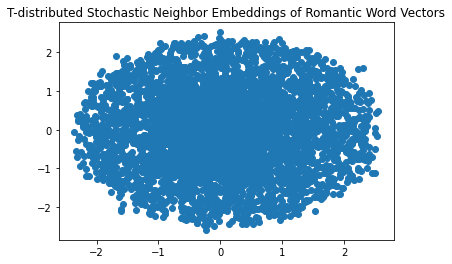

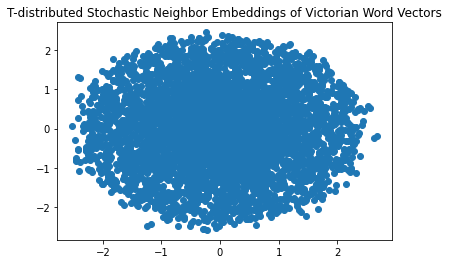

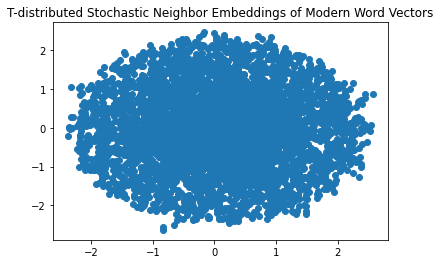

In [27]:
tsne_ro = manifold.TSNE(perplexity=100, n_iter=500, init="pca", learning_rate="auto").fit_transform(ro_embeds.numpy())
tsne_vi = manifold.TSNE(perplexity=100, n_iter=500, init="pca", learning_rate="auto").fit_transform(vi_embeds.numpy())
tsne_mo = manifold.TSNE(perplexity=100, n_iter=500, init="pca", learning_rate="auto").fit_transform(mo_embeds.numpy())

xs = np.append(tsne_ro[:, 0], np.append(tsne_vi[:, 0], tsne_mo[:, 0]))
ys = np.append(tsne_ro[:, 1], np.append(tsne_vi[:, 1], tsne_mo[:, 1]))

print(len(xs))
print(len(ys))

plt.scatter(tsne_ro[:, 0], tsne_ro[:, 1])
plt.title('T-distributed Stochastic Neighbor Embeddings of Romantic Word Vectors')
plt.show()

plt.scatter(tsne_vi[:, 0], tsne_vi[:, 1])
plt.title('T-distributed Stochastic Neighbor Embeddings of Victorian Word Vectors')
plt.show()

plt.scatter(tsne_mo[:, 0], tsne_mo[:, 1])
plt.title('T-distributed Stochastic Neighbor Embeddings of Modern Word Vectors')
plt.show()